In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
class BoostingRegressor:
    """
    Boosting Regressor (Gradient Boosting for Regression).

    Attributes:
        n_estimators (int): The number of trees in the ensemble.
        learning_rate (float): The learning rate for boosting.
        max_depth (int): The maximum depth of the trees.
    """
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        """
        Initializes the BoostingRegressor.

        Args:
            n_estimators (int, optional): The number of trees in the ensemble. Defaults to 100.
            learning_rate (float, optional): The learning rate. Defaults to 0.1.
            max_depth (int, optional): The maximum depth of the trees. Defaults to 3.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = [] # Will store all trained trees (plus initial prediction)
        self.initial_prediction = None  # Store the initial prediction

    def fit(self, X, y):
        """
        Builds the boosting ensemble from the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        n_samples = X.shape[0]

        # Start by predicting the mean of y — this is our baseline model
        self.initial_prediction = np.mean(y)  # Initialize prediction with the mean of the target
        self.trees.append(self.initial_prediction) #store the initial prediction as the first element in the trees list

        # Calculate residuals from initial prediction
        residuals = y - self.initial_prediction

        # Iteratively fit trees to the residuals
        for _ in range(self.n_estimators):
            # 1. Fit a decision tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)  # Store the tree

            # 2. Update the predictions (in place)
            new_predictions = tree.predict(X)
            residuals = residuals - self.learning_rate * new_predictions # Update residuals for the next iteration

    def predict(self, X):
        """
        Predicts the output for the given data by summing the predictions of all trees.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        predictions = np.full(X.shape[0], self.initial_prediction)  # Initialize with the initial prediction
        for tree in self.trees[1:]: # Skip the first element (the initial constant)
            predictions += self.learning_rate * tree.predict(X)  # Add the weighted predictions of each tree
        return predictions

    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [5]:
class DecisionTreeRegressor:
    """
    Decision Tree Regressor.

    Attributes:
        max_depth (int): The maximum depth of the tree.
    """
    def __init__(self, max_depth=None):
        """
        Initializes the DecisionTreeRegressor.

        Args:
            max_depth (int, optional): The maximum depth of the tree. Defaults to None (unlimited depth).
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Builds the decision tree from the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """
        Predicts the output for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        predictions = [self._predict_one(x, self.tree) for x in X]
        return np.array(predictions)

    def _build_tree(self, X, y, depth):
        """
        Recursively builds the decision tree.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
            depth (int): The current depth of the tree.

        Returns:
            dict: A dictionary representing the decision tree node.
        """
        n_samples, n_features = X.shape

        # Base cases:
        # 1. If there are no more samples, return the mean of the target values.
        if n_samples == 0:
            return {'value': np.mean(y)}
        # 2. If all target values are the same, return that value.
        if np.all(y == y[0]):
            return {'value': y[0]}
        # 3. If the maximum depth is reached, return the mean of the target values.
        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': np.mean(y)}
        # 4. If there are no more features to split on
        if n_features == 0:
            return {'value': np.mean(y)}

        # Try to find the best possible feature and threshold to split on
        best_split = self._get_best_split(X, y)

        # If no good split is found, return the mean of the target values
        if best_split['feature_index'] is None:
            return {'value': np.mean(y)}

        # Split data and recursively build left and right subtrees
        left_X, left_y = best_split['left_X'], best_split['left_y']
        right_X, right_y = best_split['right_X'], best_split['right_y']

        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)

        # Return the node
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left_child': left_child,
            'right_child': right_child,
        }

    def _get_best_split(self, X, y):
        """
        Finds the best split for the data based on the variance reduction.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).

        Returns:
            dict: A dictionary containing the best split information.
                {'feature_index': int, 'threshold': float, 'left_X': ndarray, 'left_y': ndarray,
                 'right_X': ndarray, 'right_y': ndarray}
        """
        n_samples, n_features = X.shape
        if n_features == 0:
            return {}

        # Calculate the initial variance
        initial_variance = np.var(y)
        best_variance_reduction = 0
        best_split = {}

        for feature_index in range(n_features):
            # Get the unique values of the feature
            feature_values = np.unique(X[:, feature_index])
            #consider all values as thresholds
            for threshold in feature_values:
                # Split the data based on the threshold
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_X, left_y = X[left_mask], y[left_mask]
                right_X, right_y = X[right_mask], y[right_mask]

                # Calculate the variance reduction
                if len(left_y) > 0 and len(right_y) > 0:
                    left_variance = np.var(left_y)
                    right_variance = np.var(right_y)
                    variance_reduction = initial_variance - (len(left_y) / n_samples) * left_variance - (
                        len(right_y) / n_samples
                    ) * right_variance

                    # Update the best split if it's better than the current best
                    if variance_reduction > best_variance_reduction:
                        best_variance_reduction = variance_reduction
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'left_X': left_X,
                            'left_y': left_y,
                            'right_X': right_X,
                            'right_y': right_y,
                        }

        return best_split

    def _predict_one(self, x, node):
        """
        Predicts the output for a single data point using the decision tree.

        Args:
            x (ndarray): A single data point with shape (n_features,).
            node (dict): A dictionary representing a decision tree node.

        Returns:
            float: The predicted value.
        """
        # If the node is a leaf node, return the value
        if 'value' in node:
            return node['value']

        # Otherwise, go to the left or right child based on the feature value
        if x[node['feature_index']] <= node['threshold']:
            return self._predict_one(x, node['left_child'])
        else:
            return self._predict_one(x, node['right_child'])
        
    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [7]:
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Features and target
features = ['Barrel%', 'EV', 'LA', 'wOBA', 'HardHit%']
target = 'WAR'

# Drop missing values
df = df.dropna(subset=features + [target])

# Extract X and y
X = df[features].values
y = df[target].values

# Normalize
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [9]:
estimator_range = list(range(1, 41, 2))
train_r2 = []
test_r2 = []

for n in estimator_range:
    model = BoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)

    train_r2.append(model.score(X_train, y_train))
    test_r2.append(model.score(X_test, y_test))

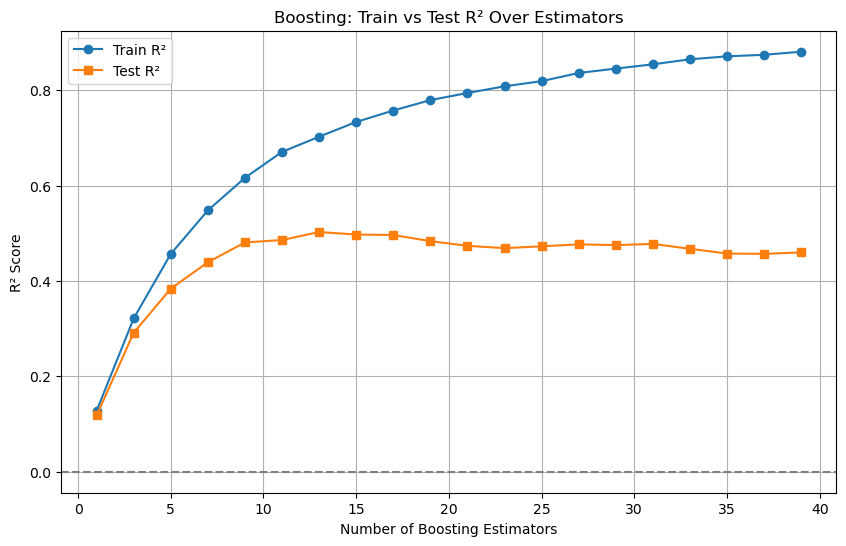

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_r2, label='Train R²', marker='o')
plt.plot(estimator_range, test_r2, label='Test R²', marker='s')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Number of Boosting Estimators")
plt.ylabel("R² Score")
plt.title("Boosting: Train vs Test R² Over Estimators")
plt.legend()
plt.grid(True)
plt.show()

This plot reveals how training and test R² evolve as the number of boosting estimators increases. The training R² rises quickly and continues to improve with each iteration, indicating the model’s increasing ability to fit the training data. The test R², however, plateaus around 13 estimators and begins to slightly decline then oscillate, suggesting that additional trees beyond this point contribute to overfitting. This behavior reflects a common dynamic in boosting where too many estimators can lead to excellent in-sample performance but poor generalization.

In [13]:
best_n = estimator_range[np.argmax(test_r2)]
best_model = BoostingRegressor(n_estimators=best_n, learning_rate=0.1, max_depth=3)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best number of estimators: {best_n}")
print(f"Final RMSE: {rmse:.2f}")
print(f"Final MAE: {mae:.2f}")
print(f"Final R² Score: {r2:.2f}")

Best number of estimators: 13
Final RMSE: 1.34
Final MAE: 1.03
Final R² Score: 0.50


At 13 estimators, the model achieves its optimal test performance: RMSE = 1.34, MAE = 1.03, and R² = 0.50. These metrics are a marked improvement from the decision tree and random forest models, both of which had negative R² values. Notably, the low MAE indicates that even individual prediction errors are reasonably small, pointing to both stability and precision. This confirms that boosting effectively captures the underlying structure of the data when stopped at the right point.

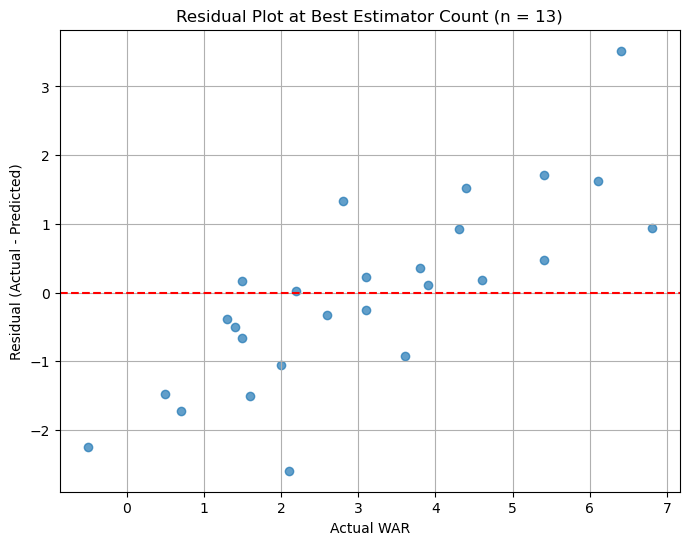

In [15]:
# Residuals at best estimator
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual WAR")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot at Best Estimator Count (n = {best_n})")
plt.grid(True)
plt.show()

The residual plot shows a tighter spread of errors compared to earlier models, with most residuals hovering around zero. Unlike the decision tree model, which produced flat, plateaued predictions, or the random forest, which slightly overpredicted across the board, boosting captures more subtle variability across the WAR range. There are still visible underpredictions at the high end (WAR > 4.5), suggesting room for improvement, but overall the error pattern is more balanced.

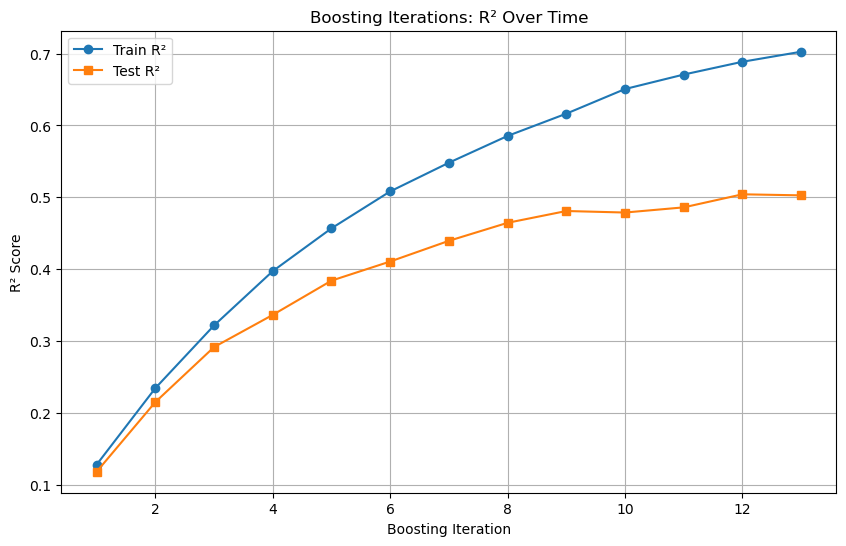

In [17]:
# Manual per-tree performance curve
train_r2_step = []
test_r2_step = []
boost_model = BoostingRegressor(n_estimators=best_n, learning_rate=0.1, max_depth=3)

# Fit manually to access intermediate predictions
boost_model.initial_prediction = np.mean(y_train)
boost_model.trees = [boost_model.initial_prediction]

pred_train = np.full(X_train.shape[0], boost_model.initial_prediction)
pred_test = np.full(X_test.shape[0], boost_model.initial_prediction)

residuals = y_train - pred_train

for _ in range(best_n):
    tree = DecisionTreeRegressor(max_depth=3)
    tree.fit(X_train, residuals)
    boost_model.trees.append(tree)
    
    pred_train += 0.1 * tree.predict(X_train)
    pred_test += 0.1 * tree.predict(X_test)

    residuals = y_train - pred_train
    train_r2_step.append(r2_score(y_train, pred_train))
    test_r2_step.append(r2_score(y_test, pred_test))

# Plot R² gain per boosting round
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_n + 1), train_r2_step, label="Train R²", marker='o')
plt.plot(range(1, best_n + 1), test_r2_step, label="Test R²", marker='s')
plt.xlabel("Boosting Iteration")
plt.ylabel("R² Score")
plt.title("Boosting Iterations: R² Over Time")
plt.legend()
plt.grid(True)
plt.show()

This plot highlights the steady gain in both training and test R² across the first 13 boosting iterations. The model’s test performance improves consistently before leveling off, indicating that each added tree incrementally corrects the prior model’s residuals. The clean separation between training and test curves is a visual cue that while boosting is powerful, its strength is bounded by the bias-variance tradeoff. This makes careful tuning of the number of iterations essential.

Boosting clearly outperforms the baseline models by building predictions in stages and correcting for prior errors. It offers strong performance without the instability of a single deep tree or the underfitting seen in random forest. However, the plots also underscore that more complexity isn’t always better, overfitting emerges quickly if the number of estimators isn’t tuned. Boosting works best when controlled, and its iterative nature gives it the nuance needed to handle structured, medium-sized data like WAR prediction.